In [224]:
from graspy.simulations import sbm
from graspy.embed import AdjacencySpectralEmbed as ase
from graspy.utils import symmetrize
from scipy.spatial.distance import pdist
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [57]:
FONTSIZE=20
def double_plot(A, X):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    sns.heatmap(A, ax=ax[0], xticklabels=False, yticklabels=False, cbar=False, cmap='Blues')
    sns.scatterplot(X[:,0], X[:,1], ax=ax[1],alpha = 0.5,s=100)
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
    ax[0].set_title('Adjacency matrix', fontsize=FONTSIZE)
    ax[1].set_title('Adjacency spectral embedding',fontsize=FONTSIZE)
    plt.show()
    return

In [226]:
n = [25,25]
p = np.array([
    [.9,.1],
    [.1,.9]
])
l = 0.9
p2 = np.array([
    [l,.1],
    [.1,l]
])
l = .5
p3 = np.array([
    [l,.1],
    [.1,l]
])

In [227]:
A = sbm(n,p)
x1 = ase(2).fit_transform(A)
B = sbm(n,p2)
x2 = ase(2).fit_transform(B)
C = sbm(n,p3)
x3 = ase(2).fit_transform(C)

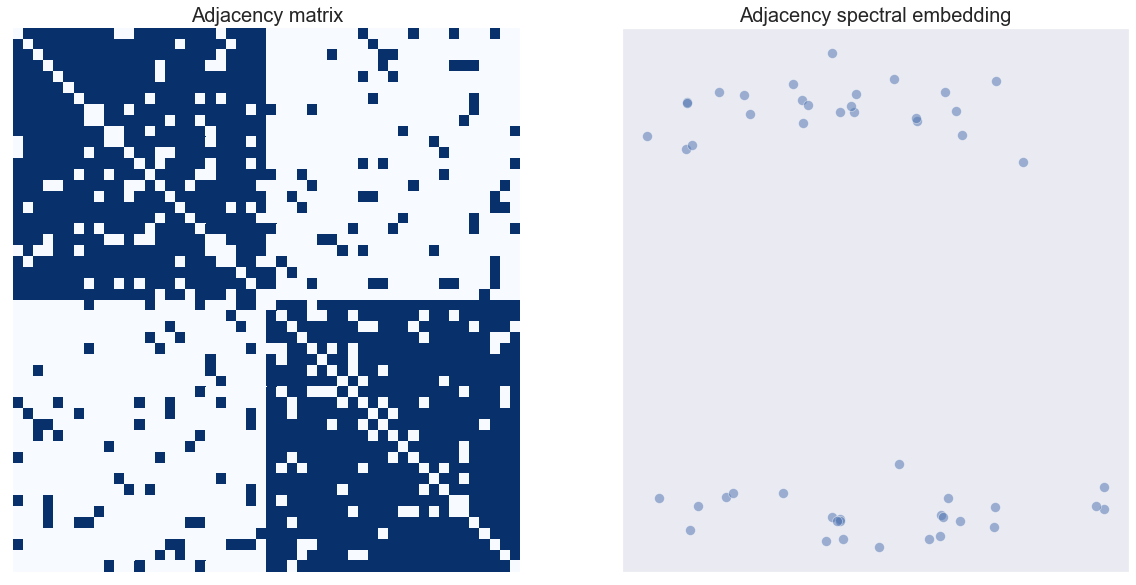

In [142]:
double_plot(A,x1)

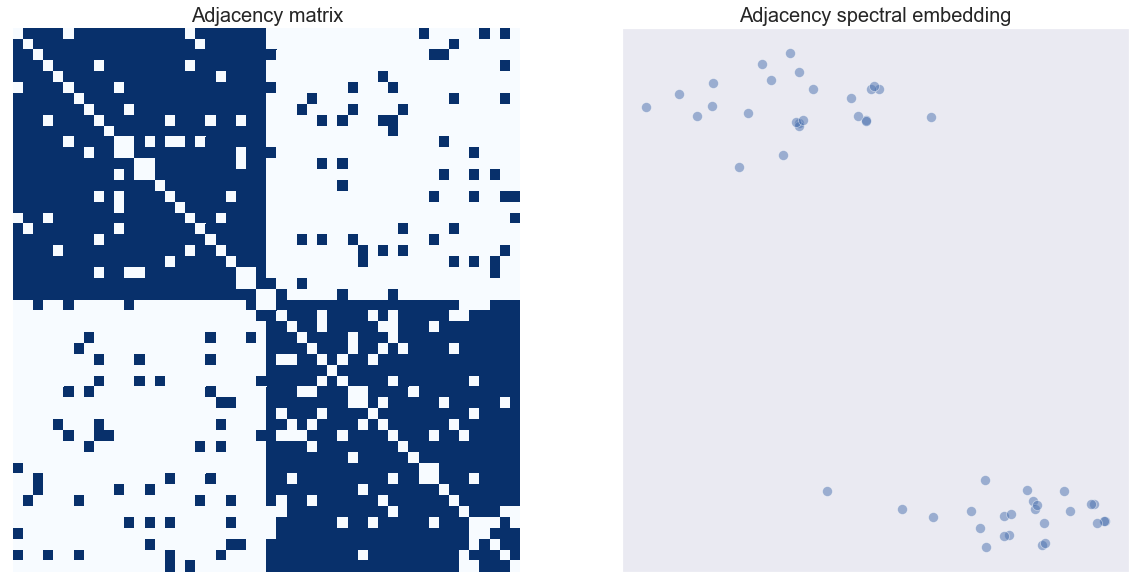

In [143]:
double_plot(B,x2)

In [144]:
print(x1.shape, x2.shape)
print(x1[0])

(50, 2) (50, 2)
[0.72319385 0.58617143]


In [145]:
z = np.concatenate((x1,x2),axis=0)
z.shape

(100, 2)

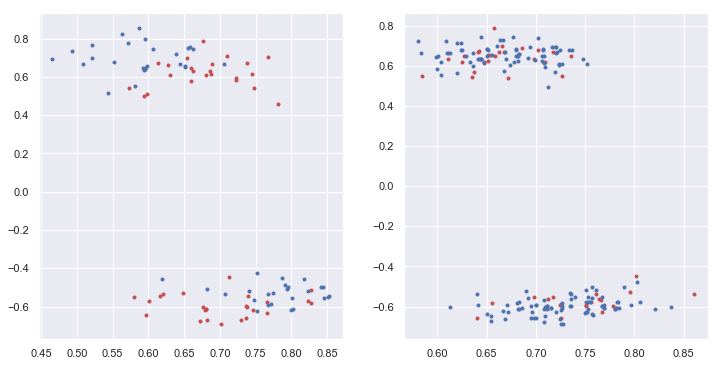

In [146]:
fig = plt.figure(figsize=(12,6))
plt.subplot(121)
lz = len(z)//2
plt.plot(z[:lz,0],z[:lz,1],'r.')
plt.plot(z[lz:,0],z[lz:,1],'b.')
np.random.shuffle(z)
plt.subplot(122)
plt.plot(zs[:lz:,0],zs[:lz,1],'r.')
plt.plot(zs[lz:,0],zs[lz:,1],'b.')
plt.show()

In [157]:
def dist_matrix(z):
    dists = pdist(z, 'euclidean')
    zlen = len(z)
    ind = np.triu_indices(zlen,k=1)
    k = np.zeros((zlen,zlen))
    k[ind] = dists
    return symmetrize(k)

def gaussian_kernel(k):
    k = np.exp(-k/np.median(k))
    return k

In [158]:
k = dist_matrix(z)
k2 = gaussian_kernel(k)

In [168]:
print(np.median(k))
print(k.shape, k2.shape)
print(np.all(k >= 0))
print(np.diag(k), np.diag(k2))

0.6628269511892891
(100, 100) (100, 100)
True
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


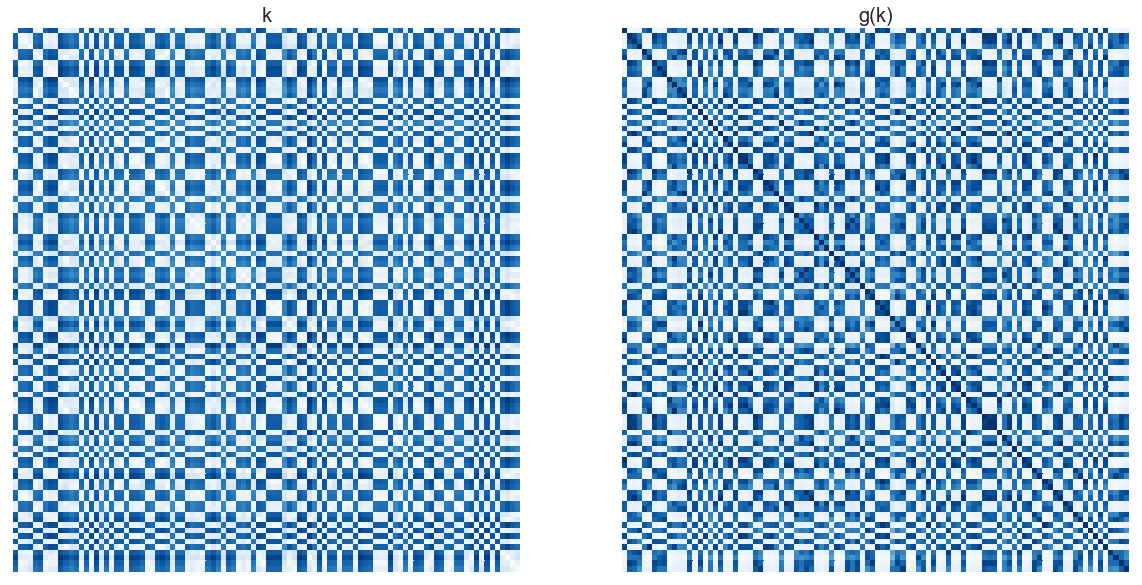

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.heatmap(k, ax=ax[0], xticklabels=False, yticklabels=False, cbar=False, cmap='Blues')
sns.heatmap(k2, ax=ax[1], xticklabels=False, yticklabels=False, cbar=False, cmap='Blues')
ax[0].set_title('k', fontsize=FONTSIZE)
ax[1].set_title('g(k)',fontsize=FONTSIZE)
plt.show()

In [179]:
def calc_u(k,n):
    return np.mean(k[:n,:n]) + np.mean(k[n:,n:]) -2*np.mean(k[:n,n:])

def u_from_z(z,n):
    k = dist_matrix(z)
    gk = gaussian_kernel(k)
    u = calc_u(gk,n)
    return u

In [194]:
def boot(x,y,n_boot=200):
    z = np.concatenate((x,y))
    utrue = u_from_z(z,len(x))
    boots = []
    for _ in range(n_boot):
        np.random.shuffle(z)
        u = u_from_z(z,len(x))
        boots.append(u)
    return boots, utrue

In [217]:
b, utrue = boot(x1,x2)
crit = np.percentile(b,95)

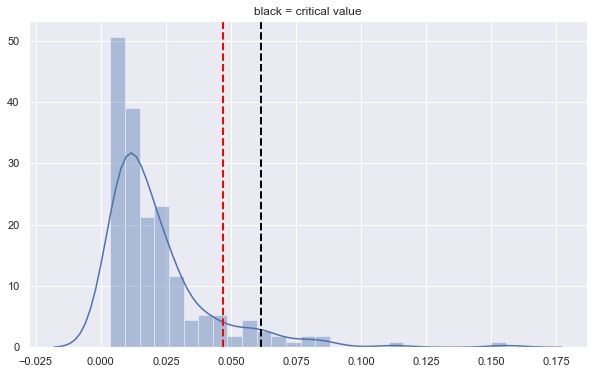

In [225]:
ax = plt.subplots(figsize=(10,6))[1]
sns.distplot(b, ax=ax)
ax.axvline(crit, linestyle='--',
           color='black', linewidth=2)
ax.axvline(utrue, linestyle='--',
           color='red', linewidth=2)
plt.title('black = critical value')
plt.show()

In [235]:
import numpy as np
from graspy.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed, OmnibusEmbed, select_dimension
from graspy.simulations import rdpg
from graspy.utils import import_graph, is_symmetric

In [246]:
#compile stuff together
#from .base import BaseInference

class NonparametricTest(): #BaseInference
    """
    Two sample hypothesis test for the nonparamatric problem of determining
    whether two random dot product graphs have the same latent positions.
    Parameters
    ----------
    embedding : string, { 'ase' (default), 'lse', 'omnibus'}
        String describing the embedding method to use.
        Must be one of:
        'ase'
            Embed each graph separately using adjacency spectral embedding
            and use Procrustes to align the embeddings.
        'lse'
            Embed each graph separately using laplacian spectral embedding
            and use Procrustes to align the embeddings.
        'omnibus'
            Embed all graphs simultaneously using omnibus embedding.
    n_components : None (default), or Int
        Number of embedding dimensions. If None, the optimal embedding
        dimensions are found by the Zhu and Godsi algorithm.
    """
    def __init__(self, embedding='ase', n_components=None, n_bootstraps=200,):
        if type(n_bootstraps) is not int:
            raise TypeError()

        if n_bootstraps < 1:
            raise ValueError('{} is invalid number of bootstraps, must be greater than 1'.format(n_bootstraps))

        #super().__init__(embedding=embedding, n_components=n_components,)
        self.embedding = embedding
        self.n_components = n_components
        self.n_bootstraps = n_bootstraps
    
    def _bootstrap(self,x,y,n_boot=200):
        z = np.concatenate((x,y))
        boots = []
        for _ in range(n_boot):
            np.random.shuffle(z)
            u = u_from_z(z,len(x))
            boots.append(u)
        return boots
        
    def _u_from_z(self,z,n):
        k = self._dist_matrix(z)
        gk = np.exp(-k/np.median(k))
        u = np.mean(gk[:n,:n]) + np.mean(gk[n:,n:]) -2*np.mean(gk[:n,n:])
        return u

    def _dist_matrix(self,z):
        dists = pdist(z, 'euclidean')
        zlen = len(z)
        ind = np.triu_indices(zlen,k=1)
        k = np.zeros((zlen,zlen))
        k[ind] = dists
        return symmetrize(k)
    
    def _embed(self, A1, A2):
        if self.embedding not in ['ase', 'lse', 'omnibus']:
            raise ValueError('Invalid embedding method "{}"'.format(self.embedding))
        if self.embedding == 'ase':
            X1_hat = AdjacencySpectralEmbed(self.n_components).fit_transform(A1)
            X2_hat = AdjacencySpectralEmbed(self.n_components).fit_transform(A2)
        elif self.embedding == 'lse':
            X1_hat = LaplacianSpectralEmbed(self.n_components).fit_transform(A1)
            X2_hat = LaplacianSpectralEmbed(self.n_components).fit_transform(A2)
        elif self.embedding == 'omnibus':
            X_hat_compound = OmnibusEmbed(self.n_components).fit_transform((A1, A2))
            X1_hat = X_hat_compound[:A1.shape[0],:]
            X2_hat = X_hat_compound[A2.shape[0]:,:]

        return (X1_hat, X2_hat)
    
    def fit(self, A1, A2):
        A1 = import_graph(A1)
        A2 = import_graph(A2)
        if not is_symmetric(A1) or not is_symmetric(A2):
            raise NotImplementedError() # TODO asymmetric case

        if self.n_components is None:
            num_dims1 = select_dimension(A1)[0][-1]
            num_dims2 = select_dimension(A2)[0][-1]
            self.n_components = max(num_dims1, num_dims2)
            
        X_hats = self._embed(A1, A2)
        U_sample = self._u_from_z(np.concatenate(X_hats), len(X_hats[0]))
        U_bootstrap = self._bootstrap(X_hats[0],X_hats[1])

        self.U_bootstrap = U_bootstrap
        self.U_sample = U_sample
        return U_sample

In [271]:
from graspy.plot import heatmap

In [272]:
A = sbm([50,50],np.array([[.9,.1],[.1,.9]]))
B = sbm([50,50],np.array([[.7,.4],[.4,.7]]))

In [273]:
nonpar = NonparametricTest()
nonpar.fit(A,B)
dist = nonpar.U_bootstrap
sample = nonpar.U_sample
crit = np.percentile(dist,95)

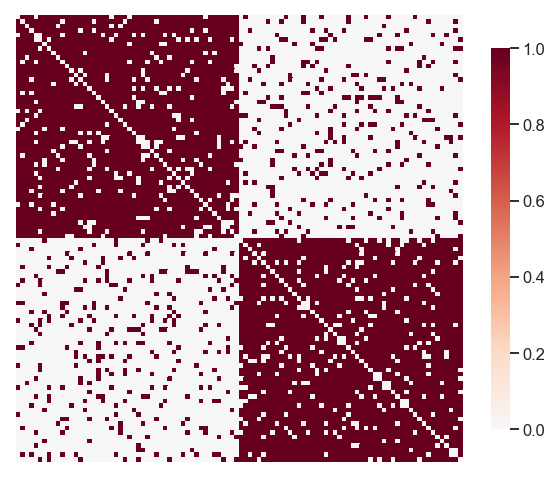

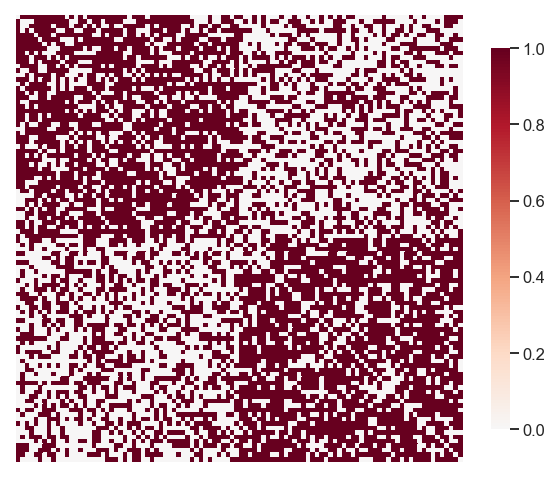

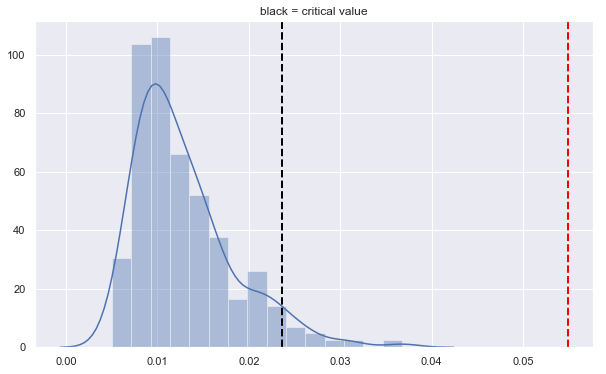

In [275]:
heatmap(A)
heatmap(B)
ax = plt.subplots(figsize=(10,6))[1]
sns.distplot(dist, ax=ax)
ax.axvline(crit, linestyle='--',
           color='black', linewidth=2)
ax.axvline(sample, linestyle='--',
           color='red', linewidth=2)
plt.title('black = critical value')
plt.show()